In [58]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from sklearn.ensemble import IsolationForest
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from math import sqrt
from sklearn.metrics import mean_squared_error

%matplotlib inline
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

In [59]:
df_train = pd.read_csv('./data/anonymized_train_data.csv')
df_train.Country.value_counts()

Germany        55
CHINA          55
Switzerland    55
Ireland        55
USA            55
Name: Country, dtype: int64

In [60]:
df_train = df_train[df_train.Country=='Germany']

In [61]:
count_a_vals = df_train['AP Adj'].values
diffs_a = count_a_vals[:-1] - count_a_vals[1:]
count_b_vals = df_train['Cost'].values
diffs_b = count_b_vals[:-1] - count_b_vals[1:]

In [62]:
df_train = df_train.iloc[1:].copy().reset_index()

In [63]:
df_train['cash_flow'] = np.array(diffs_a)
df_train['net_cost'] = np.array(diffs_b)

In [64]:
df_train = df_train[['Country', 'Date', 'cash_flow', 'net_cost']]

In [65]:
df_train.head()

,Country,Date,cash_flow,net_cost
0,Germany,2015-02-01,-0.399532,0.521632
1,Germany,2015-03-01,-0.334198,-0.509698
2,Germany,2015-04-01,-0.212772,0.625039
3,Germany,2015-05-01,-0.189466,-0.592284
4,Germany,2015-06-01,0.112739,0.342129


In [66]:
df_train.set_index(pd.DatetimeIndex(df_train['Date']),inplace = True)
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
cash_flow,54.0,-0.046953,0.302801,-1.141097,-0.203959,-0.001956,0.130357,0.680214
net_cost,54.0,-0.026845,1.185905,-3.617717,-0.534788,0.015454,0.568043,4.340782


In [67]:
df_train['Year'] = df_train.index.year
df_train['Month'] = df_train.index.month

In [68]:
df_train.head()

,Country,Date,cash_flow,net_cost,Year,Month
Date,,,,,,
2015-02-01,Germany,2015-02-01,-0.399532,0.521632,2015,2
2015-03-01,Germany,2015-03-01,-0.334198,-0.509698,2015,3
2015-04-01,Germany,2015-04-01,-0.212772,0.625039,2015,4
2015-05-01,Germany,2015-05-01,-0.189466,-0.592284,2015,5
2015-06-01,Germany,2015-06-01,0.112739,0.342129,2015,6


In [69]:
df_train.sort_index(inplace=True)

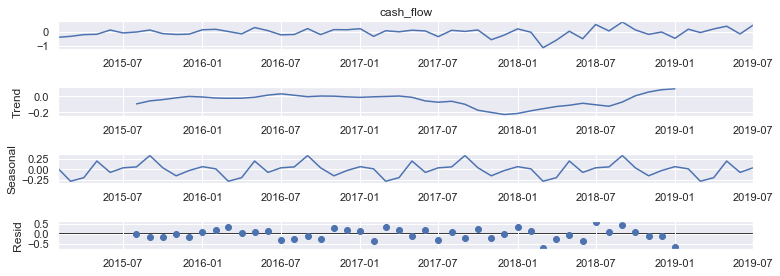

In [70]:
decomposition = sm.tsa.seasonal_decompose(df_train.cash_flow, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

In [71]:
# df_train = df_train[df_train.Date != '2015-01-01']

In [72]:
# df_train.loc['2015-01']

In [73]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
cash_flow,54.0,-0.046953,0.302801,-1.141097,-0.203959,-0.001956,0.130357,0.680214
net_cost,54.0,-0.026845,1.185905,-3.617717,-0.534788,0.015454,0.568043,4.340782
Year,54.0,2016.851852,1.337520,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000
Month,54.0,6.277778,3.394872,1.000000,3.250000,6.000000,9.000000,12.000000


In [74]:
def show_country_trends(df_train,val='net_cost'):
    for country in df_train['Country'].unique().tolist():
        df_train[df_train['Country']==country][val].plot()
        print(country)
        plt.show()

Germany


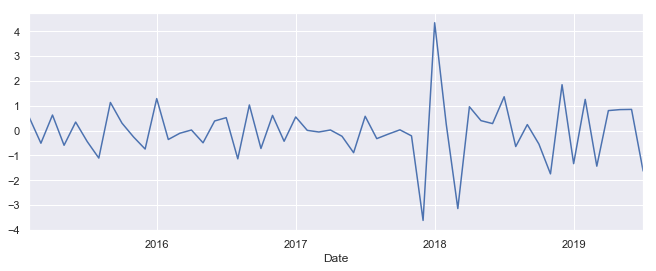

In [75]:
show_country_trends(df_train,val='net_cost')

Germany


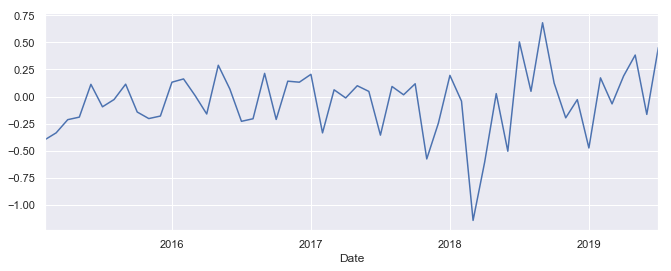

In [76]:
show_country_trends(df_train,val='cash_flow')

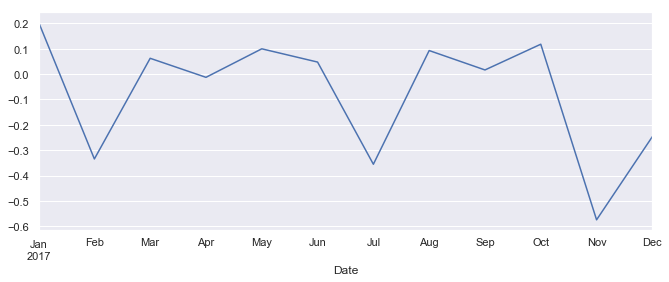

In [77]:
ax = df_train.loc['2017', 'cash_flow'].plot()

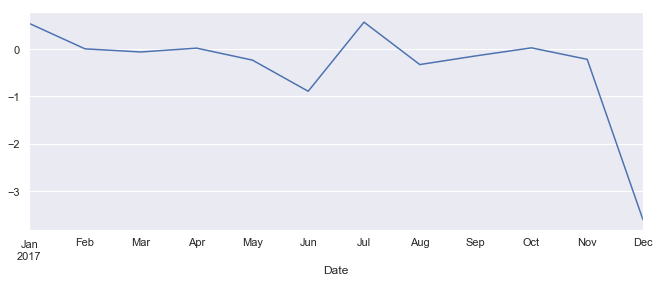

In [78]:
ax = df_train.loc['2017', 'net_cost'].plot()

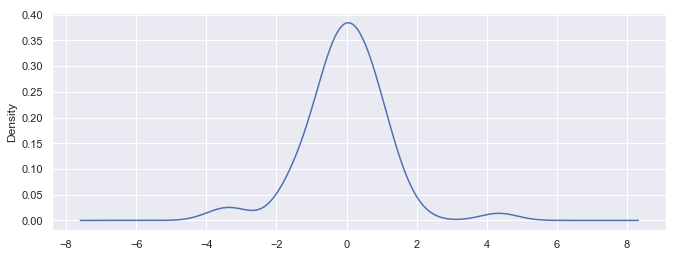

In [79]:
df_train['net_cost'].plot(kind='kde')
plt.show()

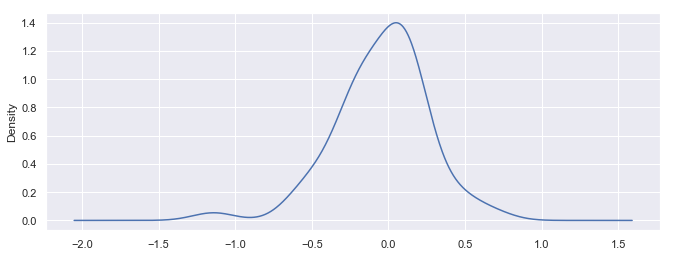

In [80]:
df_train['cash_flow'].plot(kind='kde')
plt.show()

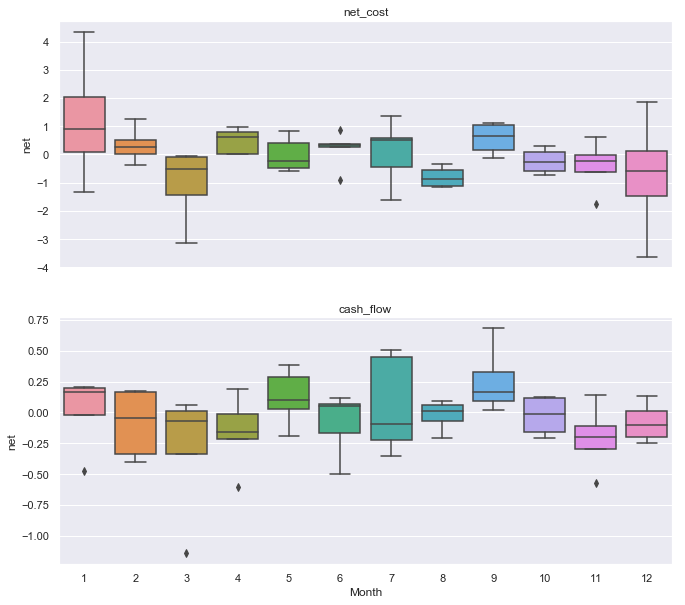

In [81]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['net_cost','cash_flow'], axes):
    sns.boxplot(data=df_train, x='Month', y=name, ax=ax)
    ax.set_ylabel('net')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

In [82]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['cash_flow', 'net_cost']
# Resample to weekly frequency, aggregating with mean
df_train_mean = df_train[data_columns].resample('W').mean()
df_train_mean.head(3)

,cash_flow,net_cost
Date,,
2015-02-01,-0.399532,0.521632
2015-02-08,NaN,NaN
2015-02-15,NaN,NaN


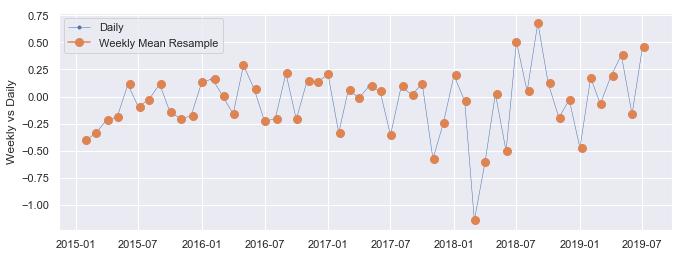

In [83]:
# Start and end of the date range to extract
start, end = '2015-01', '2019-07'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(df_train.loc[start:end, 'cash_flow'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df_train_mean.loc[start:end, 'cash_flow'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Weekly vs Daily')
ax.legend();

In [84]:
# as seen then cash flow start increasing towards the end of the year and decreasing at the start of the year.

In [85]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result[:-1]

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [86]:
data = df_train.copy()
df_train = df_train[['cash_flow']]

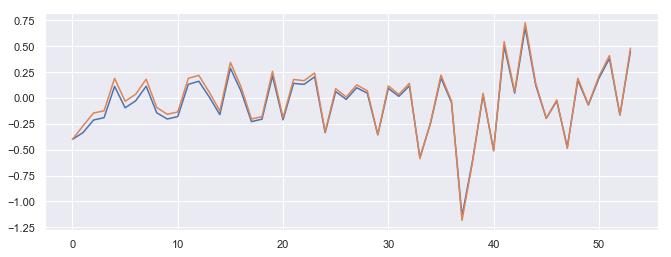

In [87]:
plt.plot(df_train.cash_flow.values, label = "Actual")
plt.plot(double_exponential_smoothing(df_train.cash_flow, 1.0, 0.05))

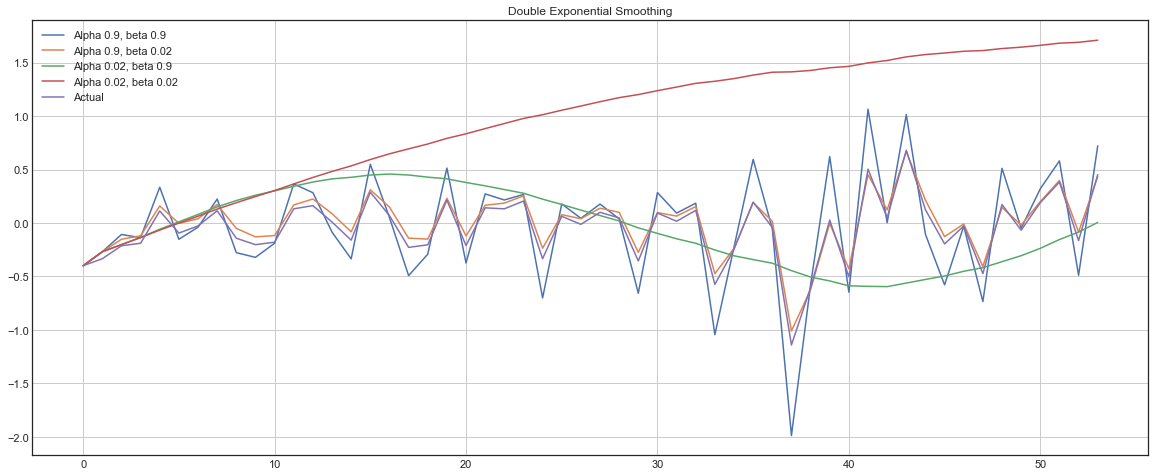

In [88]:
plotDoubleExponentialSmoothing(df_train.cash_flow, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [89]:
def outlier_smoothing(X, contamination=0.15, smoothing_window=4, plot=True, random_state=22, verbose=True):
    """
    Outlier identification by IForest and 
    smoothing by rolling window median value
    """

    X_rolling_median = X.rolling(smoothing_window).median()
    X_rolling_mean = X.rolling(smoothing_window).mean()
    X_smoothing_ratio = X / X_rolling_median

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_rolling_median, label='rolling median')
        plt.title("Original vs. Rolling Median")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,10))
        plt.plot(X.index, X_smoothing_ratio, label="original:smoothing ratio")
        plt.title("Smoothing Ratio")
        plt.legend()
        plt.show()
    
    ## Find the outliers
    iso_forest = IsolationForest(contamination=contamination,\
        random_state=random_state)
    peaks = np.where(iso_forest.fit_predict(X_smoothing_ratio[smoothing_window-1:].\
        values.reshape(-1,1))<1)
    if verbose:
        print("Outliers found at ", X.index[peaks[0]+smoothing_window-1])
    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index.values[peaks[0]+smoothing_window-1],\
            X.values[peaks[0]+smoothing_window-1], 'x'
            )
        plt.title("Outlier Finders")
        plt.legend()
        plt.show()
    ## Change the outliers with corresponding smoothed values    
    X_smoothed = X.copy()

    for i in range(len(X)):
        if np.any(peaks[0]+smoothing_window-1==i):
            X_smoothed[i] = X_rolling_mean[i]

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_smoothed, label='smoothed')
        plt.title("Original vs. smoothed")
        plt.legend()
        plt.show()
    
    return X_smoothed

def smooth(full_data):
    
    for i in full_data.columns:
        full_data[i] = outlier_smoothing(full_data[i].dropna(), plot=True)
#     for i in full_data.columns:
#         if MODELS[i][0].startswith('SARIMAX'):
#             full_data[i] = outlier_smoothing(full_data[i].dropna(), plot=False)
 
    return full_data

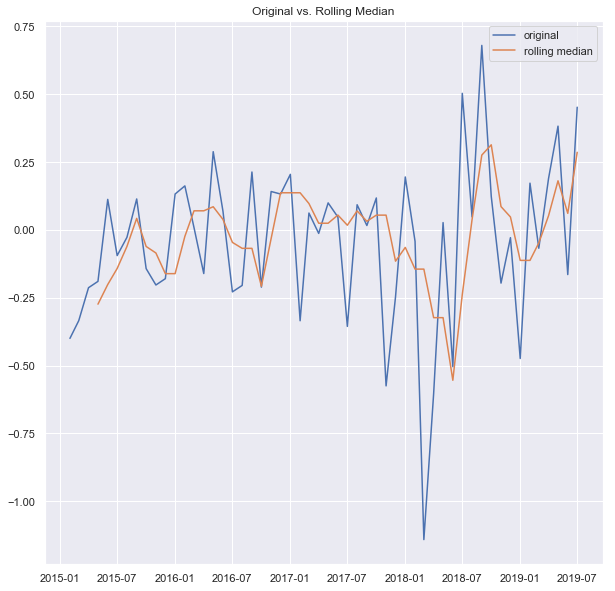

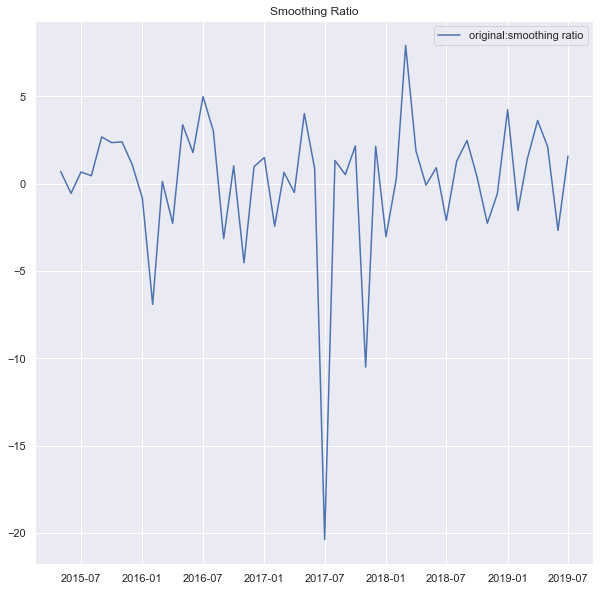

Outliers found at  DatetimeIndex(['2016-02-01', '2016-07-01', '2016-11-01', '2017-05-01',
               '2017-07-01', '2017-11-01', '2018-03-01', '2019-01-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


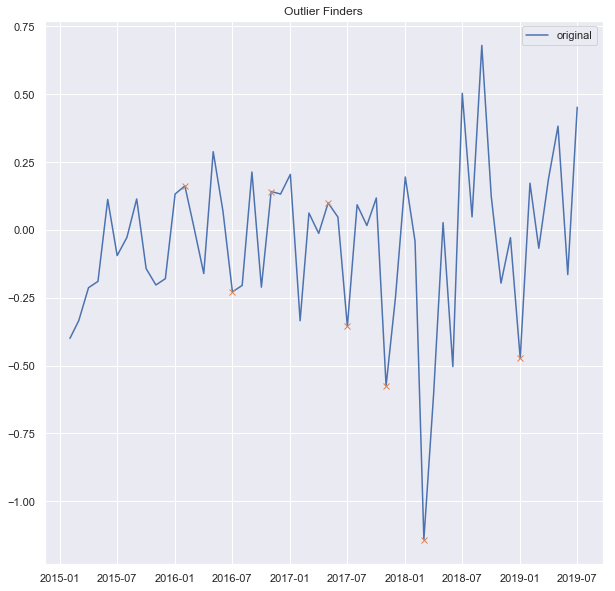

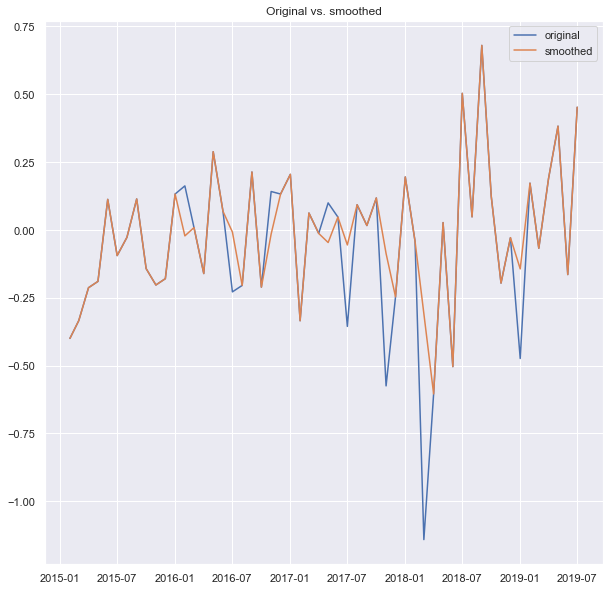

In [90]:
df_train = smooth(df_train)
# df_train.cash_flow = double_exponential_smoothing(df_train.cash_flow, 1.0, 0.05)

In [91]:
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

In [92]:
check_stationarity(df_train['cash_flow'])

The test statistic: -4.187872
p-value: 0.000691
Critical Values:
1%: -3.563
5%: -2.919
10%: -2.597


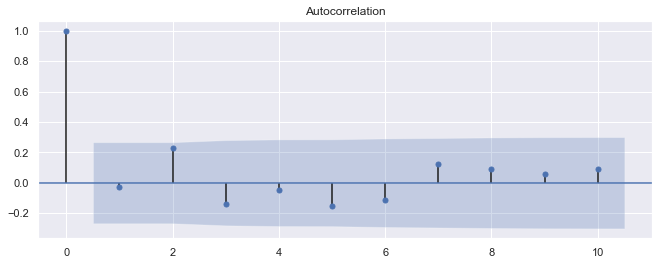

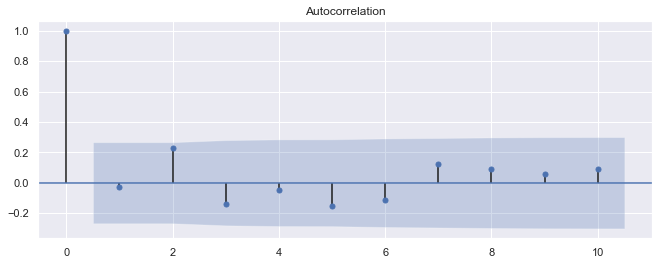

In [93]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_train['cash_flow'],lags=10)

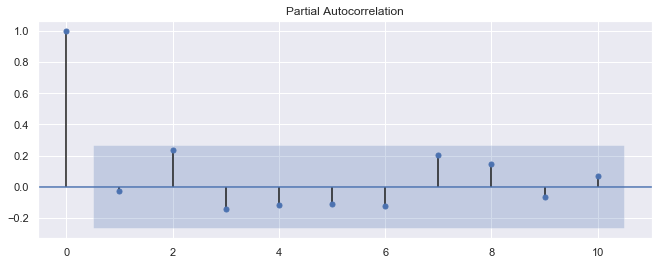

<Figure size 720x144 with 0 Axes>

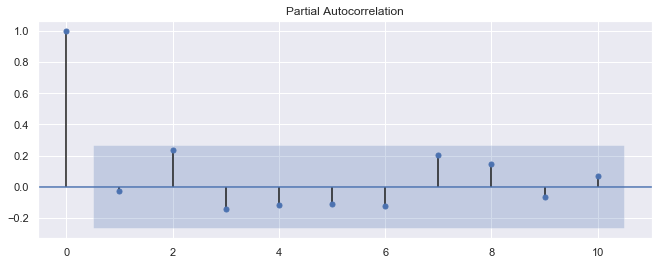

In [94]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10,2))
plot_pacf(df_train['cash_flow'],lags=10)

In [95]:
import pmdarima as pm
auto_arima_fit = pm.auto_arima(df_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=False,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

In [96]:
import itertools
def best_parameters_sarimax(series, exog=None):
    '''
    Finds the best parameters for a given series for SARIMAX algorithm.
    Input: series: the series for which the parameters are to be determined.
            exog: extra features to be considered, here price increase related
    Output: the best parameters for the series and model.
    '''
    result_param = -1
    result_param_seasonal = -1
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
#                 print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                try:
                    if results.aic < minimum:
                        result_param = param
                        result_param_seasonal = param_seasonal
                except:
                    result_param = param
                    result_param_seasonal = param_seasonal
                    minimum = results.aic
            except:
                continue
    return result_param, result_param_seasonal

In [97]:
best_param, best_param_seasonal = best_parameters_sarimax(df_train, exog=None)
best_param, best_param_seasonal

((0, 0, 0), (0, 0, 0, 12))

In [98]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(df_train,order=auto_arima_fit.order)
results_arm = mod.fit()
print(results_arm.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.cash_flow   No. Observations:                   53
Model:                 ARIMA(0, 1, 1)   Log Likelihood                   0.934
Method:                       css-mle   S.D. of innovations              0.229
Date:                Mon, 23 Nov 2020   AIC                              4.131
Time:                        17:36:27   BIC                             10.042
Sample:                    03-01-2015   HQIC                             6.404
                         - 07-01-2019                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0041      0.002      2.069      0.039       0.000       0.008
ma.L1.D.cash_flow    -1.0000      0.060    -16.770      0.000      -1.117      -0.883
                        

In [99]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                    exog=None,
                                    order=best_param,
                                    seasonal_order=best_param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              cash_flow   No. Observations:                   54
Model:                        SARIMAX   Log Likelihood                   2.192
Date:                Mon, 23 Nov 2020   AIC                             -2.385
Time:                        17:36:27   BIC                             -0.414
Sample:                    02-01-2015   HQIC                            -1.627
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0539      0.009      6.242      0.000       0.037       0.071
Ljung-Box (Q):                       31.62   Jarque-Bera (JB):                 2.95
Prob(Q):                              0.83   Pr

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


In [101]:
data = data[['cash_flow', 'net_cost','Month']]

In [102]:
y = data.cash_flow
X = data.drop(['cash_flow'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [103]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

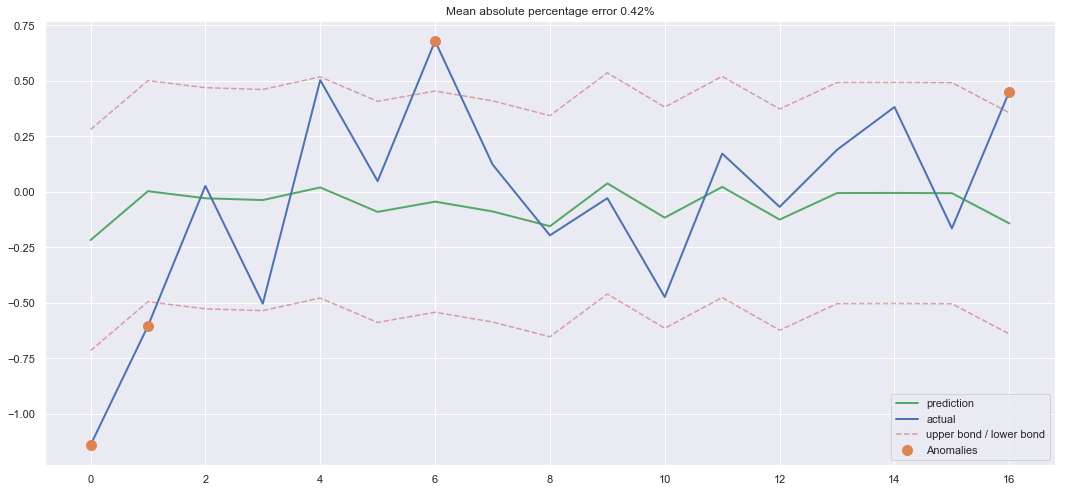

In [104]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = sqrt(mean_squared_error(prediction, y_test))
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

from math import sqrt
from sklearn.metrics import mean_squared_error

plotModelResults(lr, plot_intervals=True,plot_anomalies=True)

In [105]:
from xgboost import XGBRegressor 
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

[17:36:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

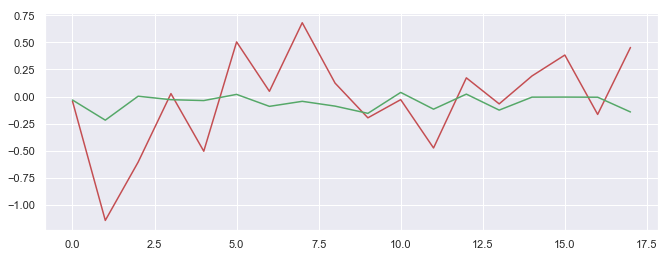

In [106]:
# lr
prediction = lr.predict(data[['net_cost','Month']].iloc[-18:])
plt.plot(data['cash_flow'].iloc[-18:].values,color='r')
plt.plot(prediction,color='g')

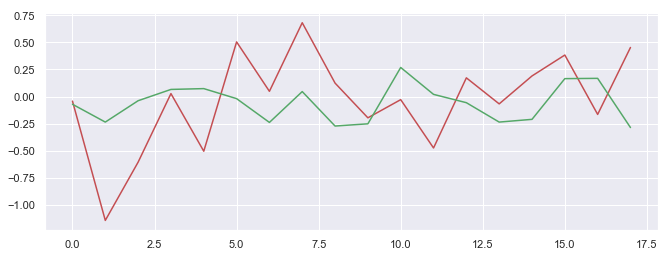

In [107]:
# xgb
prediction = xgb.predict(data[['net_cost','Month']].iloc[-18:])
plt.plot(data['cash_flow'].iloc[-18:].values,color='r')
plt.plot(prediction,color='g')

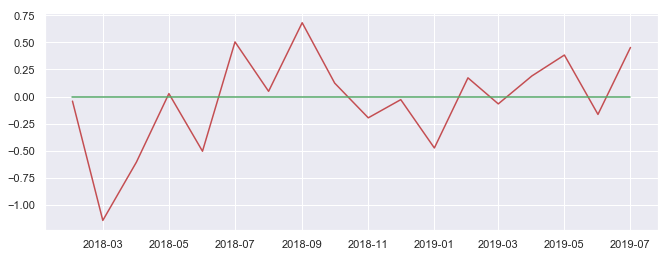

In [108]:
# sarimax
plt.plot(data['cash_flow'].iloc[-18:],color='r')
plt.plot(results.predict('2018-02-01','2019-07-01'),color='g')

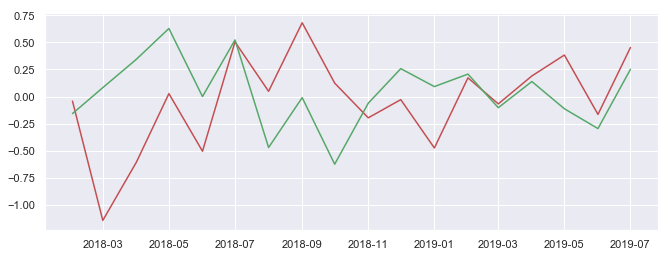

In [109]:
# arima
plt.plot(data.cash_flow[-18:],color='r')
plt.plot(results_arm.predict('2018-02-01','2019-07-01'),color='g')

In [110]:
rmse =sqrt(mean_squared_error(df_train.cash_flow, results.predict()))
print(rmse) #sarimax

0.23634477273092488


In [111]:
rmse =sqrt(mean_squared_error(df_train.cash_flow[1:], results_arm.predict()))
print(rmse) #arima

0.2951866679823933


In [112]:
prediction = lr.predict(data[['net_cost','Month']].iloc[-18:])
rmse =sqrt(mean_squared_error(data['cash_flow'].iloc[-18:].values,prediction))
print(rmse) # lr

0.4077024161355169


In [113]:
prediction = xgb.predict(data[['net_cost','Month']].iloc[-18:])
rmse =sqrt(mean_squared_error(data['cash_flow'].iloc[-18:].values,prediction))
print(rmse) # xgb

0.45140156435264495


In [114]:
#             sarimax arima lr xgb
# usa         - 0.56 0.49 0.39 0.48    - choose exponential smoothing with sarimax
# switzerland - 0.42 0.39 0.30 0.39    - choose exponential smoothing with arima
# ireland     - 0.34 0.40 0.36 0.43    - choose rolling smoothing with arima
# germany     - 0.23 0.29 0.40 0.45    - choose rolling smoothing with arima
# china       - 0.29 0.29 0.44 0.58    - choose exponential smoothing with sarimax